In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller

#### IMPORT DATA AND ESTABLISH START AND END DATES ####

In [2]:
# Create the foundational dataset
df = pd.read_csv('cpi_fah_eda_dataset.csv')
df_fcst = pd.read_csv('cpi_fah_forecast_month.csv')
df_fcst = df_fcst.set_index('month')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[(df['date'] >= '2009-01-01') & (df['date'] <= '2025-03-01')] # need to clear out all of the missing data due to lags
df = df.reset_index().set_index('date').drop(columns = 'index')

In [3]:
for col in df.columns:
    print(col)

grocery_sales
cpi_fah
restaurant_sales
oil_prices
ppi_farm_products
ppi_food_mfg
ppi_grocery
wages_retail
grocery_units
covid1
covid2
grocery_sales_diff
cpi_fah_diff
restaurant_sales_diff
oil_prices_diff
ppi_farm_products_diff
ppi_food_mfg_diff
ppi_grocery_diff
wages_retail_diff
grocery_units_diff
grocery_sales_yoy
cpi_fah_yoy
restaurant_sales_yoy
oil_prices_yoy
ppi_farm_products_yoy
ppi_food_mfg_yoy
ppi_grocery_yoy
wages_retail_yoy
grocery_units_yoy
cpi_fah_yoy_lag1
cpi_fah_yoy_lag2
cpi_fah_yoy_lag3
cpi_fah_yoy_lag4
cpi_fah_yoy_lag5
cpi_fah_yoy_lag6
cpi_fah_yoy_lag7
cpi_fah_yoy_lag8
cpi_fah_yoy_lag9
cpi_fah_yoy_lag10
cpi_fah_yoy_lag11
cpi_fah_yoy_lag12
oil_prices_yoy_lag1
oil_prices_yoy_lag2
oil_prices_yoy_lag3
oil_prices_yoy_lag4
oil_prices_yoy_lag5
oil_prices_yoy_lag6
oil_prices_yoy_lag7
oil_prices_yoy_lag8
oil_prices_yoy_lag9
oil_prices_yoy_lag10
oil_prices_yoy_lag11
oil_prices_yoy_lag12
ppi_farm_products_yoy_lag1
ppi_farm_products_yoy_lag2
ppi_farm_products_yoy_lag3
ppi_farm_produ

#### RENAME COLUMNS FOR THE MODEL ####

#### CHECK FOR MISSING VALUES ####

In [4]:
# Nothing kills a regression faster than missing data

# Count total missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

grocery_sales            1
restaurant_sales         2
grocery_units            1
grocery_sales_diff       1
restaurant_sales_diff    2
grocery_units_diff       1
grocery_sales_yoy        1
restaurant_sales_yoy     2
grocery_units_yoy        1
dtype: int64

In [5]:
df = df.ffill()

In [6]:
# Nothing kills a regression faster than missing data

# Count total missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

#### PPI MFG MODEL VS OIL PRICES ####

In [7]:
# Define independent (X) and dependent (y) variables
X = df[['oil_prices_yoy_lag1']]
y = df['ppi_farm_products_yoy']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
ppi_model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(ppi_model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['ppi_farm_products_yoy_pred'] = ppi_model.fittedvalues
df['ppi_farm_products_yoy_resid'] = ppi_model.resid

                              OLS Regression Results                             
Dep. Variable:     ppi_farm_products_yoy   R-squared:                       0.462
Model:                               OLS   Adj. R-squared:                  0.459
Method:                    Least Squares   F-statistic:                     165.5
Date:                   Sun, 13 Apr 2025   Prob (F-statistic):           9.34e-28
Time:                           20:42:22   Log-Likelihood:                -730.89
No. Observations:                    195   AIC:                             1466.
Df Residuals:                        193   BIC:                             1472.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

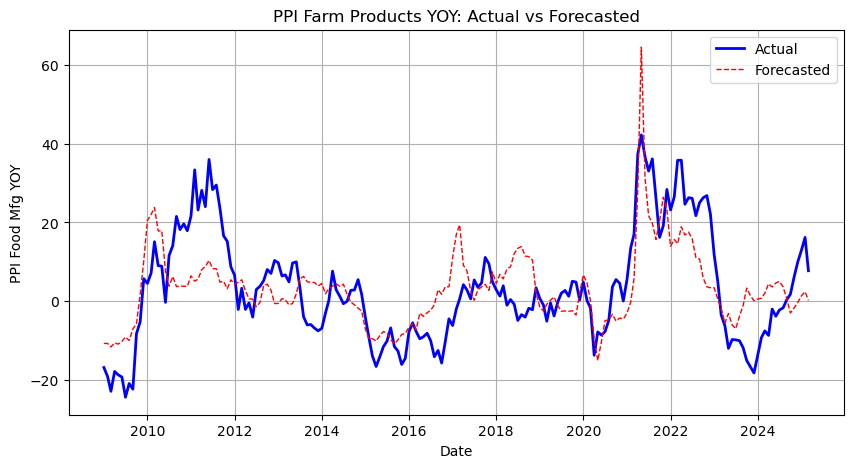

In [8]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='ppi_farm_products_yoy', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='ppi_farm_products_yoy_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('PPI Food Mfg YOY')
plt.title('PPI Farm Products YOY: Actual vs Forecasted')
plt.legend()
plt.grid(True)

plt.show()

#### CPI FAH MODEL VS PPI MEASURES ####

In [9]:
#df = df[(df.index >= '2007-01-01') & (df.index <= '2025-01-01')]

# Define independent (X) and dependent (y) variables
X = df[['ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'ppi_farm_products_yoy_lag2', 'grocery_units_yoy', 'oil_prices_yoy_lag6']]
y = df['cpi_fah_yoy']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
cpi_model = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(cpi_model.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['cpi_fah_yoy_pred'] = cpi_model.fittedvalues
df['cpi_fah_yoy_resid'] = cpi_model.resid

                            OLS Regression Results                            
Dep. Variable:            cpi_fah_yoy   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     223.2
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           2.84e-77
Time:                        20:42:22   Log-Likelihood:                -319.37
No. Observations:                 195   AIC:                             650.7
Df Residuals:                     189   BIC:                             670.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### VISUALS AND DIAGNOSTICS ####

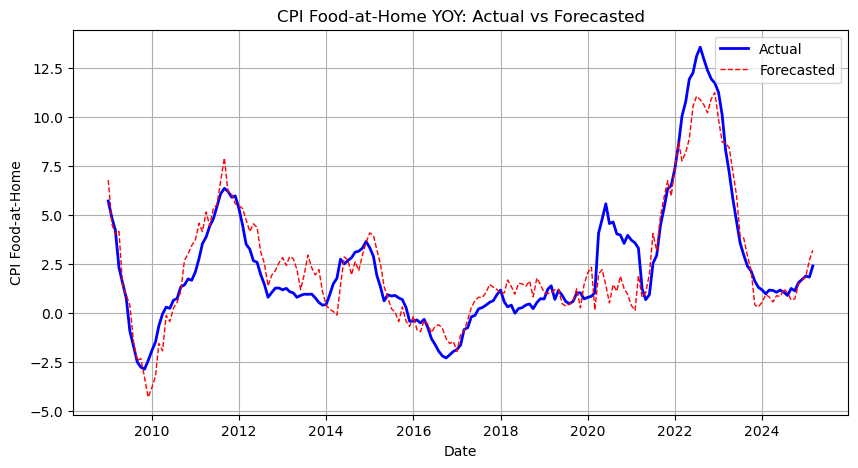

In [10]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='cpi_fah_yoy', label='Actual', linewidth=2, color='blue')
sns.lineplot(data=df, x=df.index, y='cpi_fah_yoy_pred', label='Forecasted', linewidth=1, color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('CPI Food-at-Home')
plt.title('CPI Food-at-Home YOY: Actual vs Forecasted')
plt.legend()
plt.grid(True)

plt.show()

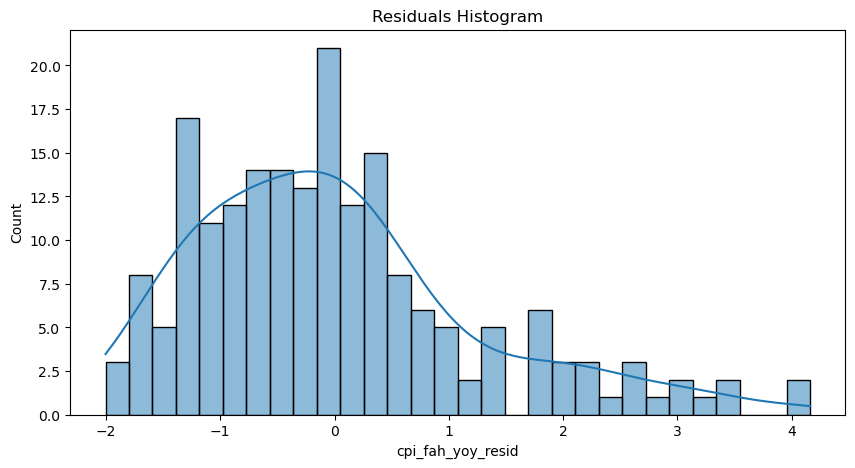

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(df["cpi_fah_yoy_resid"], bins=30, kde=True)
plt.title('Residuals Histogram')
plt.show()

<Figure size 1000x500 with 0 Axes>

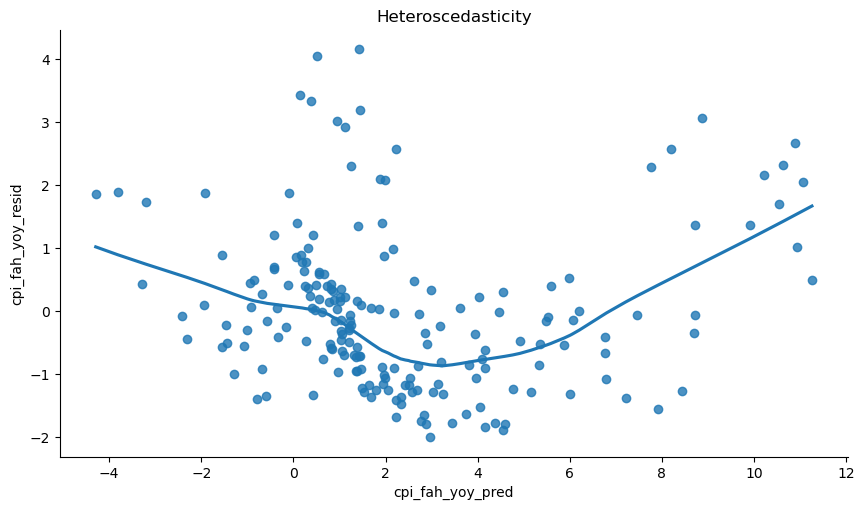

In [12]:
plt.figure(figsize=(10, 5))
sns.lmplot(x="cpi_fah_yoy_pred", y="cpi_fah_yoy_resid", data=df, lowess=True, aspect=1.75, height=5)
plt.title('Heteroscedasticity')
plt.show()

In [13]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

,Feature,VIF
0,const,2.741620
1,ppi_food_mfg_yoy_lag5,2.970776
2,ppi_grocery_yoy_lag1,1.719079
3,ppi_farm_products_yoy_lag2,1.805397
4,grocery_units_yoy,1.369830
5,oil_prices_yoy_lag6,1.757126


#### GET SE MEAN AND CONFIDENCE INTERVALS ####

In [14]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = cpi_model.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store confidence intervals
df['cpi_fah_yoy_se_mean'] = pred_summary['mean_se']  # SE of the mean
df['cpi_fah_yoy_se_lower'] = pred_summary['mean_ci_lower']  # SE of the mean
df['cpi_fah_yoy_se_upper'] = pred_summary['mean_ci_upper']  # SE of the mean
df['lower_bound'] = pred_summary['obs_ci_lower']  # SE of the mean
df['upper_bound'] = pred_summary['obs_ci_upper']  # SE of the mean

# ✅ Compute SE of the estimate (obs_se) using the upper and lower columns 
df['cpi_fah_yoy_se_obs'] = (df['upper_bound'] - df['lower_bound']) / (2 * 1.96)  # 95% CI

# # Show first few rows
df[['cpi_fah_yoy_se_mean', 'cpi_fah_yoy_se_mean', 'cpi_fah_yoy_se_obs', 'cpi_fah_yoy_se_lower', 'cpi_fah_yoy_se_upper', 
    'lower_bound', 'upper_bound']].head()

,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_mean,cpi_fah_yoy_se_obs,cpi_fah_yoy_se_lower,cpi_fah_yoy_se_upper,lower_bound,upper_bound
date,,,,,,,
2009-01-01,0.324283,0.324283,1.313550,6.155400,7.434757,4.220521,9.369637
2009-02-01,0.391531,0.391531,1.331980,3.770798,5.315461,1.932448,7.153810
2009-03-01,0.337269,0.337269,1.316858,3.359988,4.690576,1.444240,6.606324
2009-04-01,0.273164,0.273164,1.301721,3.629257,4.706939,1.616724,6.719472
2009-05-01,0.293083,0.293083,1.306102,0.803282,1.959550,-1.178545,3.941376


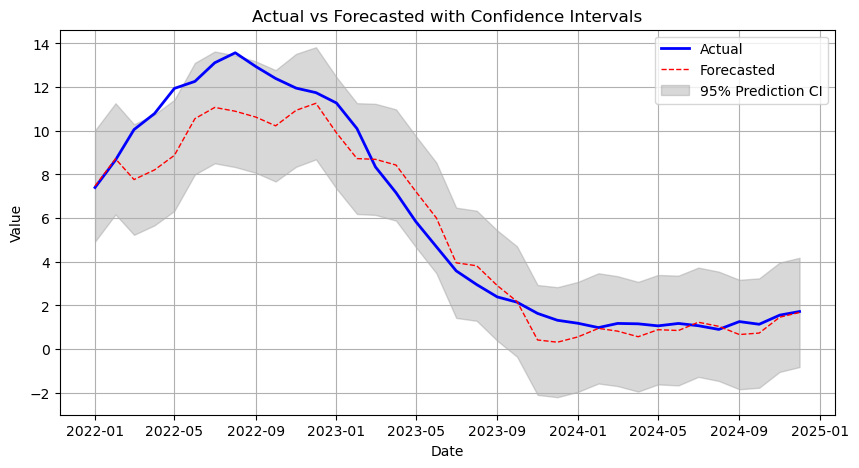

In [15]:
#Define the start and end date for filtering
start_date = '2022-01-01'
end_date = '2024-12-31'

#Filter the DataFrame to only include the desired months
df_subset = df.loc[start_date:end_date]
df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_subset, x=df_subset.index, y=df_subset['cpi_fah_yoy'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_subset, x=df_subset.index, y='cpi_fah_yoy_pred', label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_subset.index, df_subset['lower_bound'], df_subset['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


#### VALIDATE THE MODEL ####

In [16]:
# Make sure the index is datetime and sorted
df_validate = df.sort_index()
df_validate.index = pd.to_datetime(df_validate.index)  # If it's not already datetime

results = []

# Define unique months in the index
all_months = df_validate.index.to_period('M').unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 6

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]

    train_df = df_validate[df_validate.index.to_period('M').isin(train_months)]
    test_df = df_validate[df_validate.index.to_period('M').isin(test_months)]
    
    # ✅ Define train and test features and targets
    X_train = train_df[['ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'ppi_farm_products_yoy_lag2', 'grocery_units_yoy', 'oil_prices_yoy_lag6']]
    y_train = train_df["cpi_fah_yoy"]

    X_test = test_df[['ppi_food_mfg_yoy_lag5', 'ppi_grocery_yoy_lag1', 'ppi_farm_products_yoy_lag2', 'grocery_units_yoy','oil_prices_yoy_lag6']]
    y_test = test_df["cpi_fah_yoy"]
    
    # ✅ Fit model and predict
    cpi_validate = LinearRegression()
    cpi_validate.fit(X_train, y_train)
    forecast = cpi_validate.predict(X_test)

    mae = mean_absolute_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0].strftime('%Y-%m'),
        'test_end': test_months[-1].strftime('%Y-%m'),
        'MAE': mae,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)


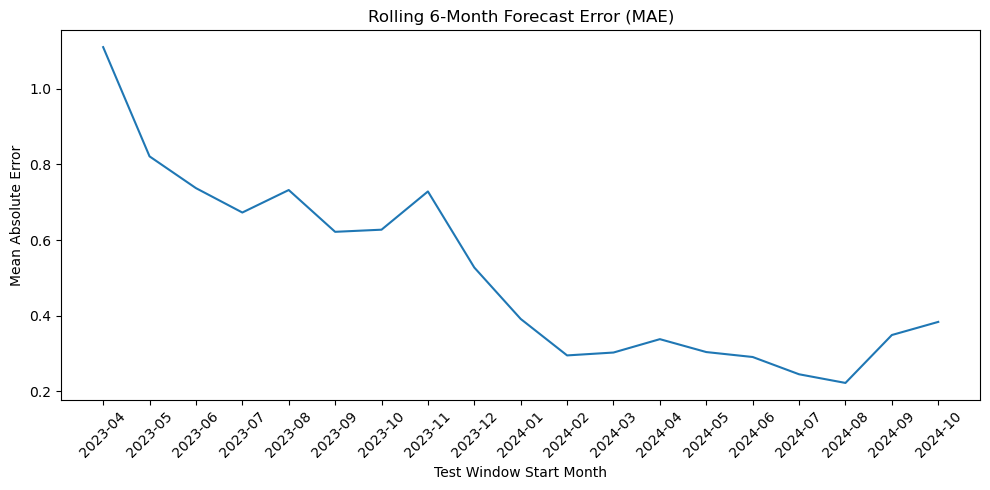

In [17]:
# Drop rows where MAE is NaN
plot_data = rolling_results_df.dropna(subset=['MAE'])

# Now plot
plt.figure(figsize=(10, 5))
plt.plot(plot_data['test_start'], plot_data['MAE'])
plt.xticks(rotation=45)
plt.title('Rolling 6-Month Forecast Error (MAE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.show()

#### FORWARD FORECAST - ESTIMATE THE INPUTS AND BUILD THE FILE ####

In [18]:
#Independent forward forecast estimates

ppi_grocery_yoy_dic = {pd.Timestamp('2025-04-01'): 2.2, pd.Timestamp('2025-05-01'): 2.2, pd.Timestamp('2025-06-01'): 2.2, pd.Timestamp('2025-07-01'): 2.2, 
                       pd.Timestamp('2025-08-01'): 2.2, pd.Timestamp('2025-09-01'): 2.2}

ppi_mfg_yoy_dic = {pd.Timestamp('2025-04-01'): 3.7, pd.Timestamp('2025-05-01'): 3.3, pd.Timestamp('2025-06-01'): 4.4, pd.Timestamp('2025-07-01'): 5.2,
                   pd.Timestamp('2025-08-01'): 4.5, pd.Timestamp('2025-09-01'): 4.5}

# six month lag. Farm product value should be six months ahead the current month
ppi_farm_products_yoy_dic = {pd.Timestamp('2025-04-01'): 12.88, pd.Timestamp('2025-05-01'): 16.18, pd.Timestamp('2025-06-01'): 7.69, pd.Timestamp('2025-07-01'): 7,
                             pd.Timestamp('2025-08-01'): 6.5, pd.Timestamp('2025-09-01'): 6.0}

us_grocery_units_yoy_dic = {pd.Timestamp('2025-04-01'): 1.8, pd.Timestamp('2025-05-01'): 1.7, pd.Timestamp('2025-06-01'): 1.6, pd.Timestamp('2025-07-01'): 1.5,
                            pd.Timestamp('2025-08-01'): 1.5, pd.Timestamp('2025-09-01'): 1.5}

oil_prices_yoy_dic = {pd.Timestamp('2025-04-01'): 8, pd.Timestamp('2025-05-01'): -6, pd.Timestamp('2025-06-01'): -21, pd.Timestamp('2025-07-01'): -16,
                      pd.Timestamp('2025-08-01'): -10, pd.Timestamp('2025-09-01'): -2}

In [19]:
df['cpi_fah_yoy_se_obs']

date
2009-01-01    1.313550
2009-02-01    1.331980
2009-03-01    1.316858
2009-04-01    1.301721
2009-05-01    1.306102
                ...   
2024-11-01    1.277728
2024-12-01    1.277094
2025-01-01    1.276424
2025-02-01    1.279085
2025-03-01    1.286167
Name: cpi_fah_yoy_se_obs, Length: 195, dtype: float64

In [20]:
df.index.dtype

dtype('<M8[ns]')

#### BUILD THE FORWARD FILE AND PREP FOR CONCAT ####

In [21]:
# Define the forward forecast period and build the file

start = pd.Timestamp("2025-04-01")
end = pd.Timestamp("2025-09-01")

# Build the df based on the date range.  The months become the index
forecast_months = pd.date_range(start, end, freq="MS")
forward_df = pd.DataFrame(index=forecast_months)

# Fill in known inputs by defining the previous year values so we can estimate the YOY values for the forecast
# THis loop grabs last years value and then applies the growth rate to calculate the future input value
# date and prev_year are the outputs that are inserted into the formulas below
for date in forecast_months:
    prev_year = date - pd.DateOffset(years=1)  

    forward_df.loc[date, "ppi_grocery_yoy_lag1"] = ppi_grocery_yoy_dic[date]
    forward_df.loc[date, "ppi_food_mfg_yoy_lag5"] = ppi_mfg_yoy_dic[date]
    forward_df.loc[date, "ppi_farm_products_yoy_lag2"] = ppi_farm_products_yoy_dic[date]
    forward_df.loc[date, "grocery_units_yoy"] = us_grocery_units_yoy_dic[date]
    forward_df.loc[date, "oil_prices_yoy_lag6"] = oil_prices_yoy_dic[date]

# Add empty columns for forecast and intervals
forward_df["cpi_fah_yoy"] = np.nan
forward_df["cpi_fah_yoy_pred"] = np.nan

# Pull the 6 months of SE values from one year ago
se_obs_values = df['cpi_fah_yoy_se_obs'].iloc[-12:-6].copy()  

# Shift the index forward to 2025
se_obs_values.index = se_obs_values.index + pd.DateOffset(years=1)

# Assign these shifted SE values into forward_df
forward_df.loc[se_obs_values.index, 'cpi_fah_yoy_se_obs'] = se_obs_values

forward_df

,ppi_grocery_yoy_lag1,ppi_food_mfg_yoy_lag5,ppi_farm_products_yoy_lag2,grocery_units_yoy,oil_prices_yoy_lag6,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs
2025-04-01,2.2,3.7,12.88,1.8,8.0,NaN,NaN,1.282017
2025-05-01,2.2,3.3,16.18,1.7,-6.0,NaN,NaN,1.278849
2025-06-01,2.2,4.4,7.69,1.6,-21.0,NaN,NaN,1.282820
2025-07-01,2.2,5.2,7.00,1.5,-16.0,NaN,NaN,1.276713
2025-08-01,2.2,4.5,6.50,1.5,-10.0,NaN,NaN,1.277541
2025-09-01,2.2,4.5,6.00,1.5,-2.0,NaN,NaN,1.279264


In [22]:
for col in forward_df.columns:
    print(col)

ppi_grocery_yoy_lag1
ppi_food_mfg_yoy_lag5
ppi_farm_products_yoy_lag2
grocery_units_yoy
oil_prices_yoy_lag6
cpi_fah_yoy
cpi_fah_yoy_pred
cpi_fah_yoy_se_obs


#### GET THE COEF FOR THE FORWARD FCST ####

In [23]:
cpi_fah_yoy_coef = {name: value for name, value in cpi_model.params.items()}
cpi_fah_yoy_coef

{'const': 0.3301852335625598,
 'ppi_food_mfg_yoy_lag5': 0.28460993847556126,
 'ppi_grocery_yoy_lag1': 0.26964272363457464,
 'ppi_farm_products_yoy_lag2': 0.05804300205912363,
 'grocery_units_yoy': -0.0758092487713069,
 'oil_prices_yoy_lag6': 0.006001698892296331}

In [24]:
const = cpi_fah_yoy_coef['const']
ppi_food_mfg_yoy_lag5 = cpi_fah_yoy_coef['ppi_food_mfg_yoy_lag5']
ppi_grocery_yoy_lag1 = cpi_fah_yoy_coef['ppi_grocery_yoy_lag1']
ppi_farm_products_yoy_lag2 = cpi_fah_yoy_coef['ppi_farm_products_yoy_lag2']
grocery_units_yoy = cpi_fah_yoy_coef['grocery_units_yoy']
oil_prices_yoy_lag6 = cpi_fah_yoy_coef['oil_prices_yoy_lag6']

#### MAKE THE FORWARD FCST ####

In [25]:
# Initialize values before the loop
forecasted_cpi_fah = []
lower_ci = []
upper_ci = []

# Loop through each row in forward_df
for i, row in forward_df.iterrows():
    y_hat = (
        const +
        ppi_food_mfg_yoy_lag5 * row['ppi_food_mfg_yoy_lag5'] +
        ppi_grocery_yoy_lag1 * row["ppi_grocery_yoy_lag1"] +
        ppi_farm_products_yoy_lag2 * row["ppi_farm_products_yoy_lag2"] +
        grocery_units_yoy * row['grocery_units_yoy'] +
        oil_prices_yoy_lag6 * row['oil_prices_yoy_lag6']
    )

    forecasted_cpi_fah.append(round(y_hat, 2))

    # Calculate and store confidence intervals
    lower_ci.append(y_hat - 1.96 * row["cpi_fah_yoy_se_obs"])
    upper_ci.append(y_hat + 1.96 * row["cpi_fah_yoy_se_obs"])

# Assign all lists to the DataFrame
forward_df['cpi_fah_yoy_pred'] = forecasted_cpi_fah
forward_df['lower_bound'] = lower_ci
forward_df['upper_bound'] = upper_ci

#### CONCAT THE FORWARD DF AND DF ####

In [26]:
# Stack the df and forward df
df_subset = df[forward_df.columns]
df_full = pd.concat([df_subset, forward_df], axis=0)
df_full.tail(12)

,ppi_grocery_yoy_lag1,ppi_food_mfg_yoy_lag5,ppi_farm_products_yoy_lag2,grocery_units_yoy,oil_prices_yoy_lag6,cpi_fah_yoy,cpi_fah_yoy_pred,cpi_fah_yoy_se_obs,lower_bound,upper_bound
2024-10-01,0.756637,1.291654,-1.744943,1.474888,7.427603,1.136562,0.733311,1.278205,-1.771970,3.238592
2024-11-01,1.678139,2.212094,0.354709,0.580579,11.800193,1.554147,1.459664,1.277728,-1.044683,3.964010
2024-12-01,1.839778,2.805668,1.735200,1.698910,13.550934,1.719773,1.678041,1.277094,-0.825064,4.181146
2025-01-01,2.354873,2.221742,6.102522,1.865908,7.533840,1.884939,1.855461,1.276424,-0.646330,4.357251
2025-02-01,5.061854,2.322754,9.864942,2.374823,-5.778512,1.840107,2.714032,1.279085,0.207026,5.221039
2025-03-01,6.832792,2.101041,12.883239,2.374823,-21.458205,2.405630,3.209538,1.286167,0.688651,5.730424
2025-04-01,2.200000,3.700000,12.880000,1.800000,8.000000,NaN,2.640000,1.282017,0.122854,5.148360
2025-05-01,2.200000,3.300000,16.180000,1.700000,-6.000000,NaN,2.640000,1.278849,0.130317,5.143406
2025-06-01,2.200000,4.400000,7.690000,1.600000,-21.000000,NaN,2.370000,1.282820,-0.139624,4.889030
2025-07-01,2.200000,5.200000,7.000000,1.500000,-16.000000,NaN,2.600000,1.276713,0.097573,5.102289


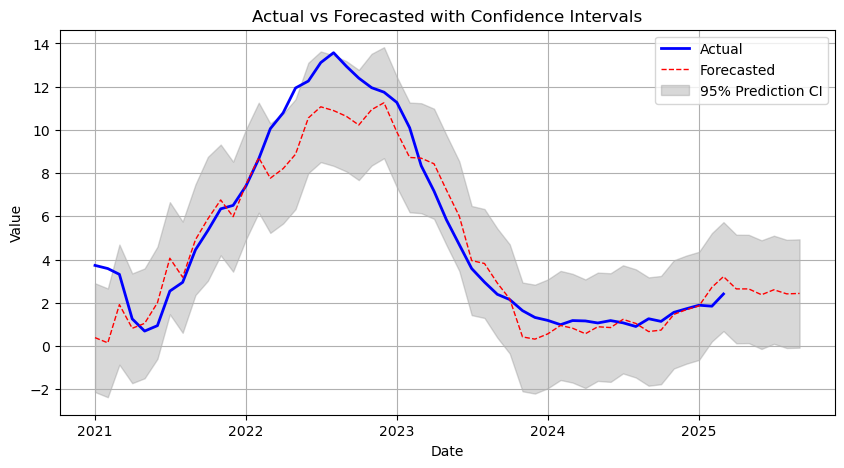

In [27]:
#Define the start and end date for filtering
start_date = '2021-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_chart = df_full.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['cpi_fah_yoy'], label='Actual', color='blue', linewidth=2.0)
sns.lineplot(data=df_chart, x=df_chart.index, y=df_chart['cpi_fah_yoy_pred'], label='Forecasted', color='red', linewidth=1.0, linestyle='dashed')

plt.fill_between(df_chart.index, df_chart['lower_bound'], df_chart['upper_bound'], color='grey', alpha=0.3, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()

In [28]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201 entries, 2009-01-01 to 2025-09-01
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ppi_grocery_yoy_lag1        201 non-null    float64
 1   ppi_food_mfg_yoy_lag5       201 non-null    float64
 2   ppi_farm_products_yoy_lag2  201 non-null    float64
 3   grocery_units_yoy           201 non-null    float64
 4   oil_prices_yoy_lag6         201 non-null    float64
 5   cpi_fah_yoy                 195 non-null    float64
 6   cpi_fah_yoy_pred            201 non-null    float64
 7   cpi_fah_yoy_se_obs          201 non-null    float64
 8   lower_bound                 201 non-null    float64
 9   upper_bound                 201 non-null    float64
dtypes: float64(10)
memory usage: 25.4 KB


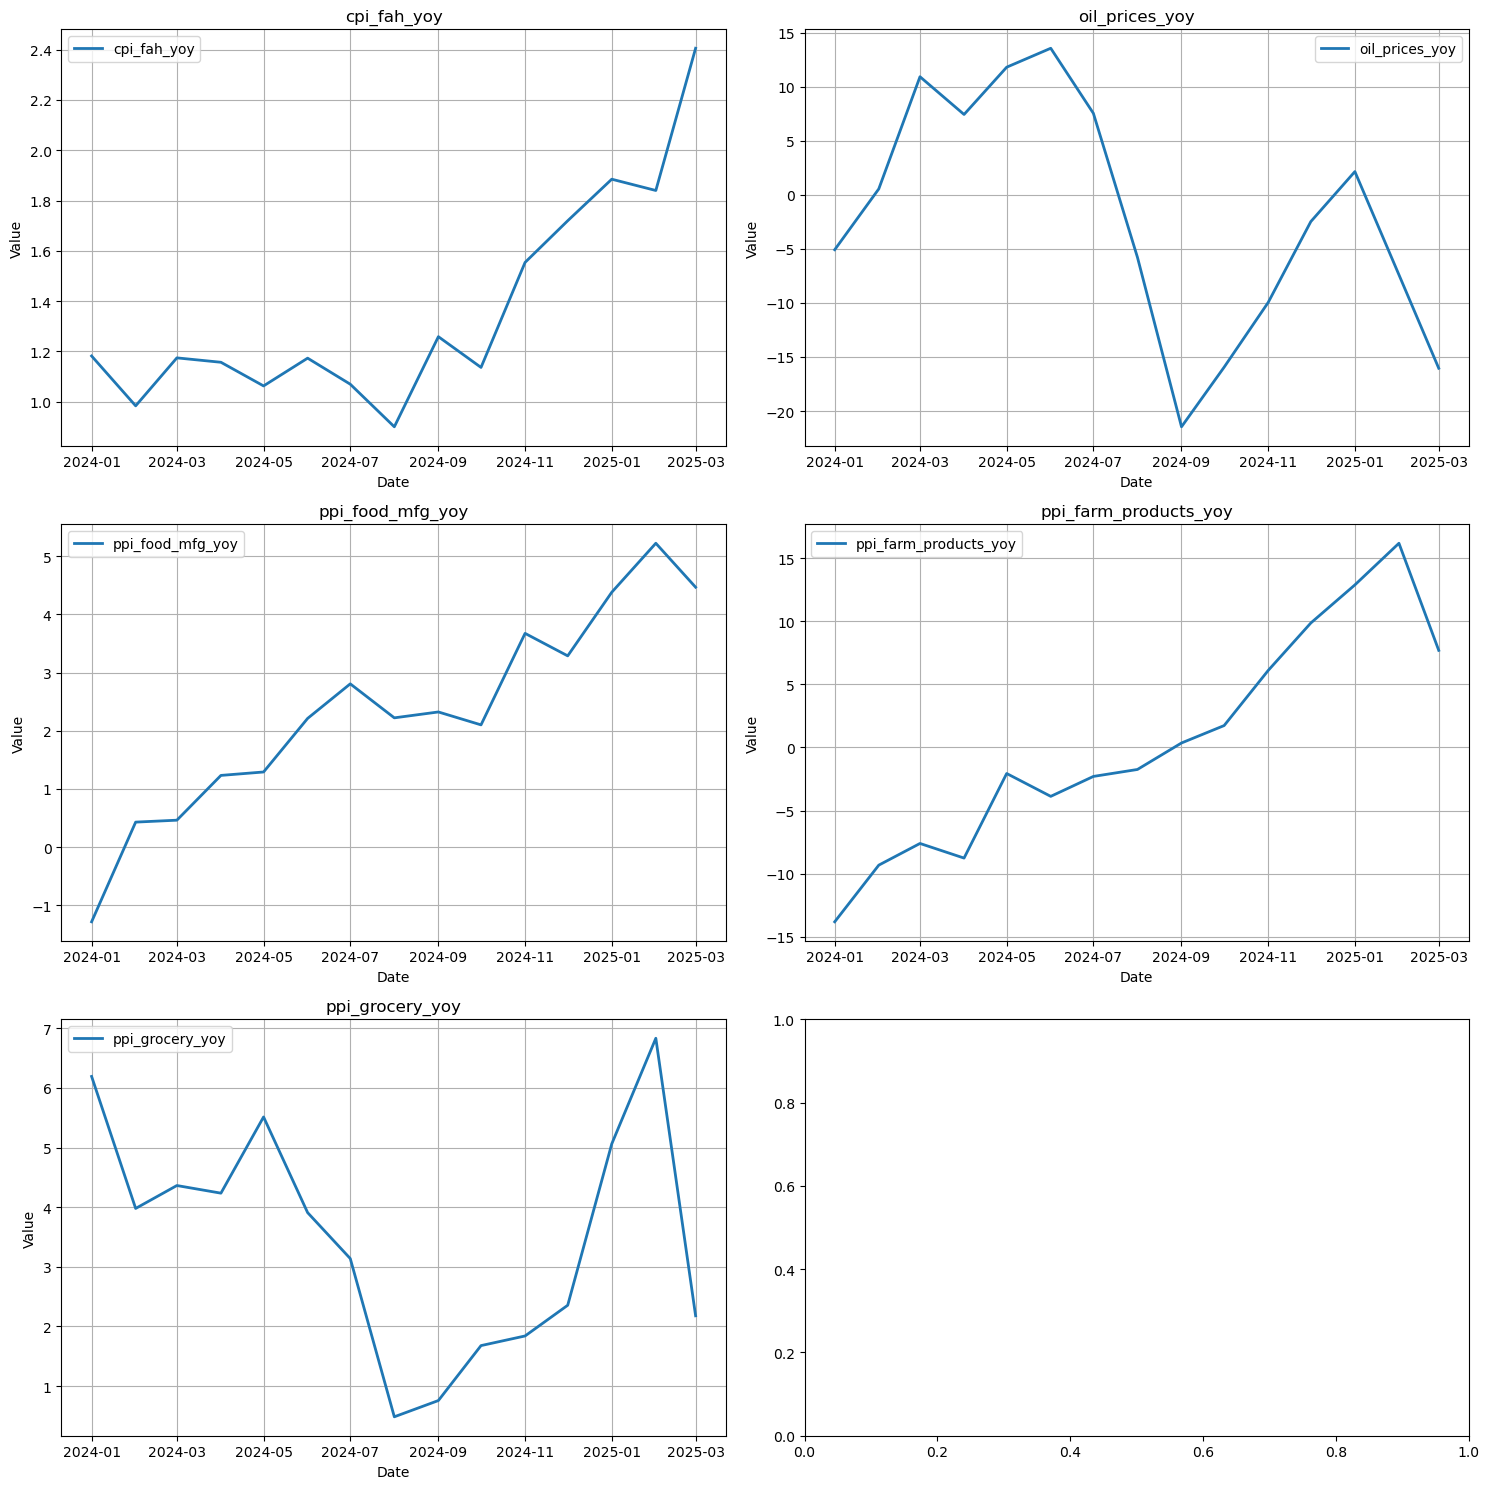

In [29]:
#Define the start and end date for filtering
start_date = '2024-01-01'
end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
df_input_charts = df.loc[start_date:end_date]

# Select the variables to plot (excluding 'date')
var_list = ['cpi_fah_yoy', 'oil_prices_yoy', 'ppi_food_mfg_yoy', 'ppi_farm_products_yoy', 'ppi_grocery_yoy']

# Create a grid of subplots (2 columns × enough rows for all variables)
num_vars = len(var_list)
rows = (num_vars // 2) + (num_vars % 2)  # Ensures enough rows for all variables

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, 5 * rows))  # Dynamically sized

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each variable and plot
for i, col in enumerate(var_list):
    ax = axes[i]  # Select the subplot
    ax.plot(df_input_charts.index, df_input_charts[col], label=col, linewidth=2)
    
    # Customize the subplot
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Value", fontsize=10)
    ax.grid(True)
    ax.legend()

# Adjust layout for readability
plt.tight_layout()

# Show the plot
plt.show()

#### BUILD THE FORECAST DF ####

In [30]:
# Build a df to hold the forecasts
# Define the forward forecast period and build the file

# start = pd.Timestamp("2025-04-01")
# end = pd.Timestamp("2025-09-01")

# # Build the df based on the date range.  The months become the index
# forecast_months = pd.date_range(start, end, freq="MS")
# df_fcst = pd.DataFrame(index=forecast_months)

# df_fcst_values = df_full['cpi_fah_yoy_pred']

# df_fcst_values = df_fcst_values[df_fcst_values.index >= start]

# df_fcst = pd.merge(df_fcst, df_fcst_values, right_index=True, left_index=True, how='left')

# df_fcst

In [31]:
df_fcst

,P-2025-02,P-2025-04,Actuals
month,,,
2/1/2025,1.1,NaN,1.8
3/1/2025,1.8,NaN,2.4
4/1/2025,1.9,1.9,NaN
5/1/2025,2.5,2.4,NaN
6/1/2025,2.9,2.7,NaN
7/1/2025,3.1,2.7,NaN
8/1/2025,NaN,3.0,NaN
9/1/2025,NaN,2.5,NaN


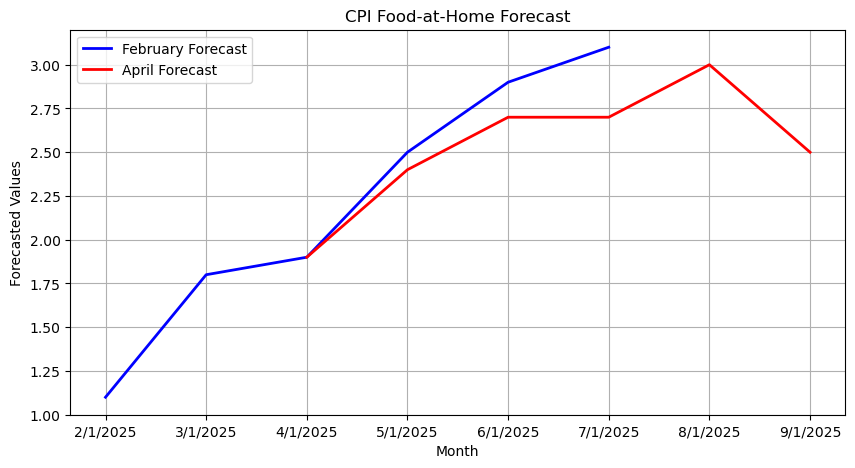

In [32]:
#Define the start and end date for filtering
#start_date = '2021-01-01'
#end_date = '2025-12-01'

#Filter the DataFrame to only include the desired months
#df_chart = df_fcst.loc[start_date:end_date]

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_fcst, x=df_fcst.index, y=df_fcst['P-2025-02'], label='February Forecast', color='blue', linewidth=2.0)
sns.lineplot(data=df_fcst, x=df_fcst.index, y=df_fcst['P-2025-04'], label='April Forecast', color='red', linewidth=2.0)
#sns.lineplot(data=df_fcst, x=df_fcst.index, y=df_fcst['Actuals'], label='Actual Values', color='black', linewidth=2.0)

plt.xlabel('Month')
plt.ylabel('Forecasted Values')
plt.title('CPI Food-at-Home Forecast')
plt.legend()
plt.grid(True)

plt.show()

In [33]:
df_fcst.to_csv('cpi_fah_forecast_month.csv')

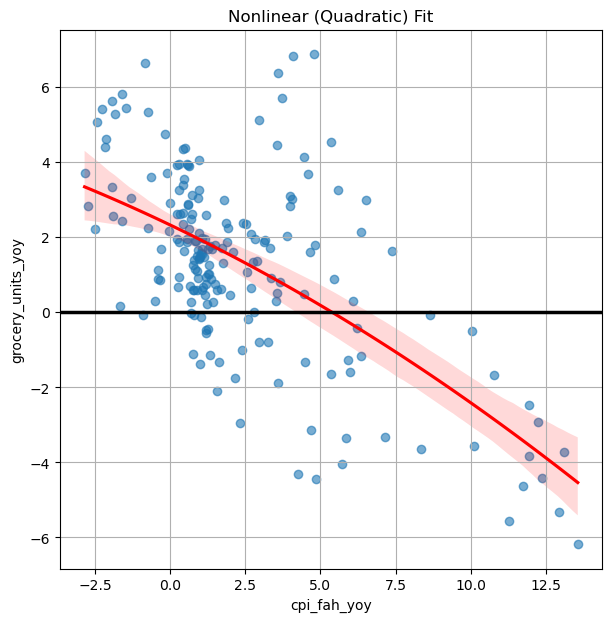

In [34]:
df_filtered = df[(df['grocery_units_yoy'] > -10) & (df['grocery_units_yoy'] < 10)]

#Plot the chart
plt.figure(figsize=(7, 7))

# Nonlinear fit using order=2 (quadratic)
sns.regplot(data=df_filtered, x='cpi_fah_yoy', y='grocery_units_yoy', order=2, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.axhline(y=0, color='black', linewidth=2.5)  # ← customize here
plt.title("Nonlinear (Quadratic) Fit")
plt.grid(True)
plt.show()